In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('sb_30-05_slim_slim-1.csv')

In [3]:
df.head()

,x,y,goalkeeper_dx,goalkeeper_dy,opposition_1_dx,opposition_1_dy,opposition_2_dx,opposition_2_dy,opposition_3_dx,opposition_3_dy,...,shot_one_on_one,shot_outcome,shot_technique,shot_statsbomb_xg,shot_type,under_pressure,prev_type,goal,prev_x,prev_y
0,100.4,35.1,18.0,3.4,1.5,0.0,5.0,-3.6,6.8,3.0,...,False,Blocked,Normal,0.056644,Open Play,False,Ball Recovery,False,101.7,35.6
1,114.6,33.5,3.7,2.9,-0.3,1.1,-1.6,3.6,0.0,5.6,...,False,Saved,Normal,0.143381,Open Play,True,Pass,False,111.0,69.2
2,106.2,55.8,12.0,-12.9,2.7,3.9,2.9,-5.0,2.7,-9.6,...,False,Blocked,Normal,0.038188,Open Play,False,Ball Recovery,False,105.8,56.5
3,113.9,47.4,5.0,-5.5,0.2,-1.0,-0.7,-0.8,-0.9,-2.3,...,False,Blocked,Normal,0.052781,Open Play,False,Pass,False,120.0,0.1
4,89.2,42.5,27.7,-2.4,2.7,1.3,3.1,-1.9,1.9,9.0,...,False,Blocked,Normal,0.021272,Open Play,True,Carry,False,87.6,46.0


In [4]:
sb_labs = df['shot_statsbomb_xg'].values

y = df['goal'].values

In [5]:
df['header'] = df['shot_body_part'] == 'Head'
df['header'] = df['header'].astype(int)
df['shot_aerial_won'] = df['shot_aerial_won'].astype(int)
df['shot_first_time'] = df['shot_first_time'].astype(int)
df['shot_one_on_one'] = df['shot_one_on_one'].astype(int)
df['under_pressure'] = df['under_pressure'].astype(int)

In [6]:
df.drop(['shot_body_part', 'shot_technique', 'shot_outcome', 'goal', 'shot_statsbomb_xg'], axis = 1, inplace = True)

In [7]:
from sklearn.model_selection import train_test_split

#X_train, X_temp, y_train, y_temp, sb_train, sb_temp = train_test_split(
 #   df, y, sb_labs, test_size=0.4, random_state=42
#)

X_train, X_test, y_train, y_test, sb_train, sb_test = train_test_split(
    df, y, sb_labs, random_state=42
)


#X_val, X_test, y_val, y_test, sb_val, sb_test = train_test_split(
 #   X_temp, y_temp, sb_temp, test_size=0.5, random_state=42
#)

In [8]:
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()

#X_train_scaled = scaler.fit_transform(X_train)

#X_test_scaled = scaler.transform(X_test)

In [9]:
print(df.dtypes)

categorical_features_indices = np.where(df.dtypes == object)[0]

x                  float64
y                  float64
goalkeeper_dx      float64
goalkeeper_dy      float64
opposition_1_dx    float64
opposition_1_dy    float64
opposition_2_dx    float64
opposition_2_dy    float64
opposition_3_dx    float64
opposition_3_dy    float64
opposition_4_dx    float64
opposition_4_dy    float64
teammate_1_dx      float64
teammate_1_dy      float64
teammate_2_dx      float64
teammate_2_dy      float64
goalkeeper_x       float64
goalkeeper_y       float64
opposition_1_x     float64
opposition_1_y     float64
opposition_2_x     float64
opposition_2_y     float64
opposition_3_x     float64
opposition_3_y     float64
opposition_4_x     float64
opposition_4_y     float64
teammate_1_x       float64
teammate_1_y       float64
teammate_2_x       float64
teammate_2_y       float64
play_pattern        object
shot_aerial_won      int32
shot_first_time      int32
shot_one_on_one      int32
shot_type           object
under_pressure       int32
prev_type           object
p

In [10]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import roc_auc_score

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [11]:
def objective(params):
    params['iterations'] = int(params['iterations'])
    params['depth'] = int(params['depth'])
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        train_pool = Pool(X_fold_train, y_fold_train, cat_features=categorical_features_indices)
        validate_pool = Pool(X_fold_val, y_fold_val, cat_features=categorical_features_indices)
        
        model = CatBoostClassifier(**params,random_seed=42, eval_metric='AUC', logging_level='Silent')
        model.fit(train_pool)
        
        y_fold_val_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_val_pred)
        scores.append(score)
    
    mean_score = np.mean(scores)
    
    return {'loss': -mean_score, 'status': STATUS_OK}

In [13]:
space = {
    'iterations': hp.quniform('iterations', 50, 990, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
}

In [14]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best params: {best}")

100%|█████████████████████████████████████████| 100/100 [26:46:52<00:00, 964.12s/trial, best loss: -0.7983788207226258]
Best params: {'depth': 8.0, 'iterations': 650.0, 'l2_leaf_reg': 5.594965503028441, 'learning_rate': 0.02114331382568456}


In [12]:
import optuna
from catboost import CatBoostClassifier, Pool
from optuna_integration import CatBoostPruningCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='optuna')


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 990),
        'learning_rate': trial.suggest_float('learning_rate', 0, 0.2),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10)
    }
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        train_pool = Pool(X_fold_train, y_fold_train, cat_features=categorical_features_indices)
        validate_pool = Pool(X_fold_val, y_fold_val, cat_features=categorical_features_indices)
        
        model = CatBoostClassifier(**params, random_seed=42, eval_metric='AUC', verbose = 0)
        pruning_callback = CatBoostPruningCallback(trial, 'AUC')

        model.fit(train_pool, eval_set = validate_pool, early_stopping_rounds = 100, callbacks = [pruning_callback])
        
        pruning_callback.check_pruned()
        
        
        y_fold_val_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_val_pred)
        scores.append(score)

    
    mean_score = np.mean(scores)
    
    return mean_score

In [13]:




#study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),direction='maximize')
#study.optimize(objective, n_trials=200, timeout = 600)

#print(f"Best params: {study.best_params}")

if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=300), direction="maximize"
   )
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-07-23 13:01:26,851] A new study created in memory with name: no-name-bf789bde-c405-414e-885a-18e46c49a2a8
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimenta

[I 2024-07-23 13:08:32,277] Trial 2 finished with value: 0.7855807588708048 and parameters: {'iterations': 805, 'learning_rate': 0.11460394120006755, 'colsample_bylevel': 0.01251475684370941, 'depth': 6, 'l2_leaf_reg': 1.595883949023734}. Best is trial 1 with value: 0.7935492525703038.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_cal

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 13:13:52,327] Trial 5 finished with value: 0.7908220585273884 and parameters: {'iterations': 572, 'learning_rate': 0.06726646920996525, 'colsample_bylevel': 0.03951155156398582, 'depth': 3, 'l2_leaf_reg': 5.998696173743509}. Best is trial 4 with value: 0.7941564962468617.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 13:13:58,816] Trial 6 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 13:33:31,584] Trial 21 finished with value: 0.7962679183259186 and parameters: {'iterations': 296, 'learning_rate': 0.10152808055117844, 'colsample_bylevel': 0.0868537880360314, 'depth': 6, 'l2_leaf_reg': 3.6311123209434037}. Best is trial 21 with value: 0.7962679183259186.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_c

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 13:39:02,397] Trial 24 finished with value: 0.796737370036079 and parameters: {'iterations': 451, 'learning_rate': 0.06769143175460846, 'colsample_bylevel': 0.06126837039934153, 'depth': 6, 'l2_leaf_reg': 5.075728980754485}. Best is trial 24 with value: 0.796737370036079.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_cal

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 13:44:48,447] Trial 27 finished with value: 0.7975450913809148 and parameters: {'iterations': 440, 'learning_rate': 0.12641785007916076, 'colsample_bylevel': 0.06436702670473438, 'depth': 5, 'l2_leaf_reg': 6.3090870214731885}. 

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 14:00:15,208] Trial 37 finished with value: 0.7962341911087648 and parameters: {'iterations': 883, 'learning_rate': 0.015906885762906643, 'colsample_bylevel': 0.07334648245467601, 'depth': 7, 'l2_leaf_reg': 4.3022394119296745}. Best is trial 27 with value: 0.7975450913809148.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 14:00:22,783] Trial 38 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experim

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 14:39:20,462] Trial 51 finished with value: 0.7972922938521074 and parameters: {'iterations': 629, 'learning_rate': 0.07483534593772728, 'colsample_bylevel': 0.07439027975711478, 'depth': 7, 'l2_leaf_reg': 7.690863940005507}. Best is trial 44 with value: 0.7977551874851139.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_c

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 15:47:24,626] Trial 69 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The int

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 15:58:44,599] Trial 73 finished with value: 0.7975160526974998 and parameters: {'iterations': 647, 'learning_rate': 0.0634899044198187, 'colsample_bylevel': 0.09967964778151686, 'depth': 7, 'l2_leaf_reg': 8.123108411148685}. Best is trial 55 with value: 0.7978381386745947.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_ca

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 16:08:10,249] Trial 77 finished with value: 0.7952664649493301 and parameters: {'iterations': 687, 'learning_rate': 0.18034348669678651, 'colsample_bylevel': 0.08495875613814717, 'depth': 8, 'l2_leaf_reg': 7.392475696207994}. B

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 16:46:07,468] Trial 99 finished with value: 0.7973794370643479 and parameters: {'iterations': 724, 'learning_rate': 0.04111371854243309, 'colsample_bylevel': 0.06487591170369984, 'depth': 7, 'l2_leaf_reg': 4.93901104954578}. Best is trial 79 with value: 0.7982917127179957.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_ca

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 17:00:34,951] Trial 111 finished with value: 0.7975001731641578 and parameters: {'iterations': 497, 'learning_rate': 0.053433798190418734, 'colsample_bylevel': 0.0796821697972547, 'depth': 6, 'l2_leaf_reg': 7.7771230474791775}. Best is trial 79 with value: 0.7982917127179957.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 17:00:47,821] Trial 112 pruned. Trial was pruned at iteration 338.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experi

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 17:27:15,726] Trial 125 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The in

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 18:00:45,207] Trial 141 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The in

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 18:11:38,355] Trial 146 finished with value: 0.798136205659518 and parameters: {'iterations': 939, 'learning_rate': 0.0642899816264911, 'colsample_bylevel': 0.08223629611818137, 'depth': 8, 'l2_leaf_reg': 8.241655497983247}. Be

[I 2024-07-23 18:18:27,298] Trial 152 finished with value: 0.7970569699182072 and parameters: {'iterations': 448, 'learning_rate': 0.06539496417263257, 'colsample_bylevel': 0.08803926068303668, 'depth': 7, 'l2_leaf_reg': 4.81872812193236}. Best is trial 121 with value: 0.7993875456614867.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 18:18:37,750] Trial 153 pruned. Trial was pruned at iteration 312.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experim

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 18:27:05,108] Trial 157 finished with value: 0.7971932101751559 and parameters: {'iterations': 503, 'learning_rate': 0.1339166772901376, 'colsample_bylevel': 0.08333693536812309, 'depth': 7, 'l2_leaf_reg': 3.472246643597979}. B

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

[I 2024-07-23 18:43:44,318] Trial 165 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 18:43:53,425] Trial 166 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: Experimenta

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(tr

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 19:05:00,741] Trial 178 finished with value: 0.797773976377125 and parameters: {'iterations': 715, 'learning_rate': 0.05388852786382123, 'colsample_bylevel': 0.07141307857160913, 'depth': 8, 'l2_leaf_reg': 7.113164535514321}. Best is trial 121 with value: 0.7993875456614867.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 19:17:03,035] Trial 181 finished with value: 0.7977705196591913 and parameters: {'iterations': 782, 'learning_rate': 0.04936473093975594, 'colsample_bylevel': 0.06964973628441559, 'depth': 8, 'l2_leaf_reg': 7.499157573111567}. Best is trial 121 with value: 0.7993875456614867.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 19:26:51,503] Trial 189 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 19:27:04,386] Trial 190 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: Experimenta

C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 19:36:05,111] Trial 198 pruned. Trial was pruned at iteration 300.
C:\Users\vikra\AppData\Local\Temp\ipykernel_16000\3139371768.py:32: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'AUC')
[I 2024-07-23 19:36:20,080] Trial 199 pruned. Trial was pruned at iteration 300.


Number of finished trials: 200
Best trial:
  Value: 0.7993875456614867
  Params: 
    iterations: 956
    learning_rate: 0.0585181522732779
    colsample_bylevel: 0.08072898859321492
    depth: 7
    l2_leaf_reg: 8.166998036852029


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, sb_train, sb_test = train_test_split(
    df, y, sb_labs, random_state=42
)


#X_train, X_val, y_train, y_val, sb_train, sb_val = train_test_split(
 #   X_temp, y_temp, sb_temp, test_size=0.3, random_state=42
#)

In [13]:
params = {

    'iterations': 500,

    'learning_rate': 0.1,

    'eval_metric': 'AUC',

    'random_seed': 42,

    'logging_level': 'Silent',

    'use_best_model': False

}

best_params = {'depth': 6.0, 'iterations': 850.0, 'l2_leaf_reg': 5.818879801139229, 
              'learning_rate': 0.027166960904798452,
             'eval_metric' : 'AUC', 'random_seed': 42,
              'logging_level': 'Silent'}

params2 = {'depth': 8.0, 'iterations': 650.0, 'l2_leaf_reg': 5.594965503028441, 
           'learning_rate': 0.02114331382568456, 'eval_metric': 'AUC',
           'random_seed': 42, 'logging_level': 'Silent',}

params3 = {'iterations': 433,
    'learning_rate': 0.044200229034504226,
    'colsample_bylevel': 0.08664405133785547,
    'depth': 8,
    'l2_leaf_reg': 3.818165835984483, 'eval_metric': 'AUC',
           'random_seed': 42, 'logging_level': 'Silent',}

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

#validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [14]:
model = CatBoostClassifier(**params3)
model.fit(train_pool)


y_pred_probs = model.predict_proba(X_test)[:, 1]



In [15]:
from sklearn.metrics import log_loss

y_test_conv = y_test.astype(int)

logloss_model = log_loss(y_test_conv, y_pred_probs)
logloss_sb = log_loss(y_test_conv, sb_test)

print(f"Model Log Loss: {logloss_model}")
print(f"Statsbomb Log Loss: {logloss_sb}")

Model Log Loss: 0.25618030730910135
Statsbomb Log Loss: 0.25385731116418275


In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test_conv, y_pred_probs)
roc_auc_sb = roc_auc_score(y_test_conv, sb_test)
print(f"My model: {roc_auc}")
print(f"SB: {roc_auc_sb}")

My model: 0.7932270481711784
SB: 0.7993221281967366


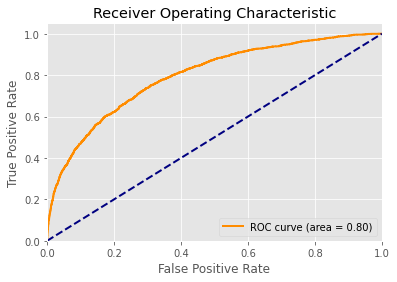

In [22]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

roc_auc = roc_auc_score(y_test_conv, y_pred_probs)

fpr, tpr, _ = roc_curve(y_test_conv, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

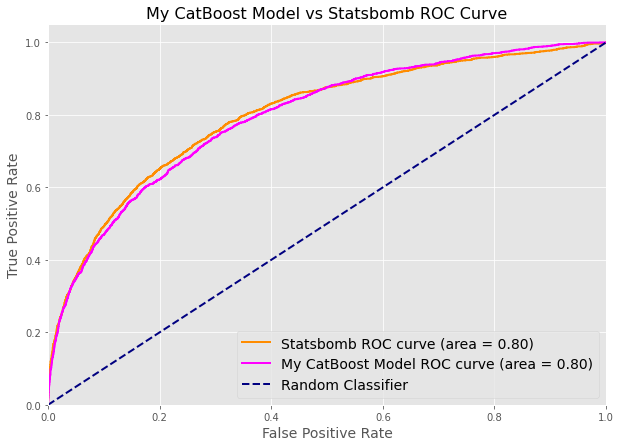

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')


roc_auc_sb = roc_auc_score(y_test_conv, sb_test)

fpr_sb, tpr_sb, _ = roc_curve(y_test_conv, sb_test)
plt.figure(figsize = (10,7))
plt.plot(fpr_sb, tpr_sb, color='darkorange', lw=2, label=f'Statsbomb ROC curve (area = {roc_auc_sb:.2f})')
plt.plot(fpr, tpr, color='#FF00FF', lw=2, label=f'My CatBoost Model ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('My CatBoost Model vs Statsbomb ROC Curve', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
#plt.savefig('06-06_attempt.png', dpi = 1000, facecolor = 'white', bbox_inches = 'tight')
plt.show()